In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

import pickle

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
LOCAL = False

if LOCAL:
    df = pd.read_csv('Final_df.csv')
    
else:
    df = pd.read_csv("/content/gdrive/My Drive/capstone project/modified datasets/Final_df.csv")


In [ ]:
df

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume,Tweet_volume,Avg_score,Avg_score_norm,Tweet_volume_norm
0,0,2021-02-05,36931.546875,38225.906250,36658.761719,38144.308594,38144.308594,58598066402,1694.0,0.000025,0.043308,0.022462
1,1,2021-02-06,38138.386719,40846.546875,38138.386719,39266.011719,39266.011719,71326033653,3278.0,0.000021,0.032583,0.044547
2,2,2021-02-07,39250.191406,39621.835938,37446.152344,38903.441406,38903.441406,65500641143,3030.0,0.000009,0.000000,0.041089
3,3,2021-02-08,38886.828125,46203.929688,38076.324219,46196.464844,46196.464844,101467222687,5647.0,0.000055,0.129953,0.077577
4,4,2021-02-09,46184.992188,48003.722656,45166.960938,46481.105469,46481.105469,91809846886,4350.0,0.000057,0.136786,0.059494
...,...,...,...,...,...,...,...,...,...,...,...,...
431,431,2022-04-12,39533.714844,40617.585938,39388.328125,40127.183594,40127.183594,30991500854,NaN,NaN,NaN,NaN
432,432,2022-04-13,40123.570312,41430.054688,39712.746094,41166.730469,41166.730469,27691105228,18397.0,0.000058,0.137809,0.255347
433,433,2022-04-14,41160.218750,41451.480469,39695.746094,39935.515625,39935.515625,24342001973,27676.0,0.000063,0.153244,0.384722
434,434,2022-04-15,39939.402344,40617.722656,39866.832031,40553.464844,40553.464844,21756855753,40576.0,0.000075,0.185499,0.564583


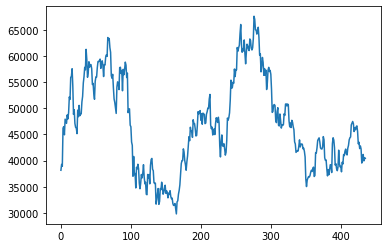

In [ ]:
df['Close'].plot()

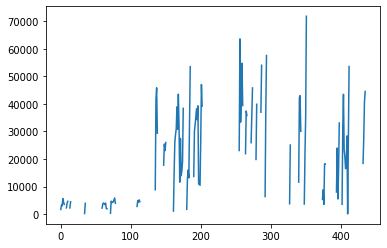

In [ ]:
df['Tweet_volume'].plot()

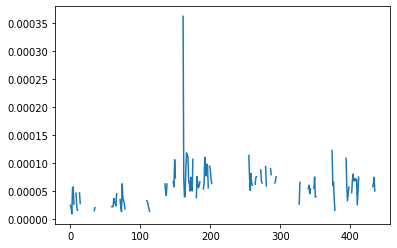

In [ ]:
df['Avg_score'].plot()

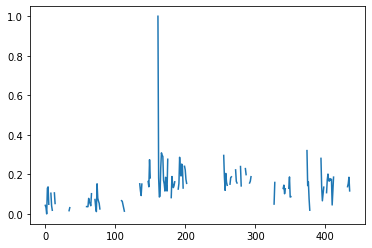

In [ ]:
df['Avg_score_norm'].plot()

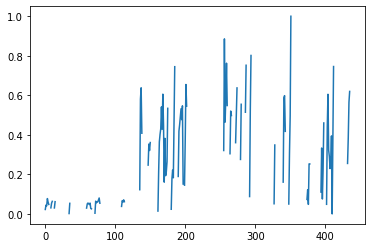

In [ ]:
df['Tweet_volume_norm'].plot()

In [ ]:
df.index=pd.to_datetime(df['Date'],format='%Y-%m-%d')

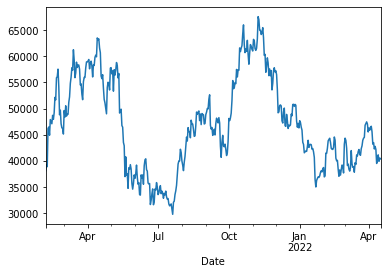

In [ ]:
df['Close'].plot()

In [ ]:
# interpolate missing values 

df.interpolate(method='time', inplace=True)

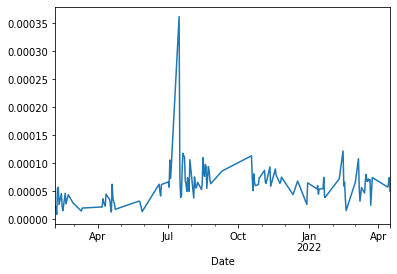

In [ ]:
df['Avg_score'].plot()

In [ ]:
train_df = df[:int(.7*len(df))]
test_df = df[int(.7*len(df)):]

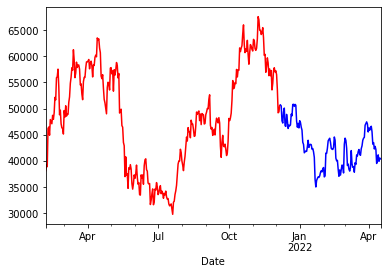

In [ ]:
train_df['Close'].plot(color='red')
test_df['Close'].plot(color='blue')

In [ ]:
#features & target for the model

features = ['Open', 'High', 'Low', 'Volume', 'Tweet_volume', 'Avg_score_norm']
target = ['Close']

In [ ]:
#features & target for the model
featureScaler = StandardScaler()
targetScaler = StandardScaler()

featureScaler.fit(train_df[features])
targetScaler.fit(train_df[target])

StandardScaler()

In [ ]:
featureScaler.mean_

array([4.87576764e+04, 5.01165990e+04, 4.72002390e+04, 4.62037701e+10,
       1.71516880e+04, 1.49834468e-01])

In [ ]:
def create_dataset(train, test):
    
    trainX = featureScaler.transform(train[features])
    trainY = targetScaler.transform(train[target])
    
    testX = featureScaler.transform(test[features])
    testY = targetScaler.transform(test[target])
    
    X_train = np.array(trainX)
    Y_train = np.array(trainY)
    
    X_test = np.array(testX)
    Y_test = np.array(testY)

    return (trainX, trainY), (testX,testY)    

In [63]:
WINDOW_SIZE = 10

(X_train, Y_train), (X_test, Y_test) = create_dataset(train_df, test_df)

In [ ]:
print(X_train)

[[-1.22084717 -1.22189406 -1.09581533  0.50065274 -1.05421442 -0.81459077]
 [-1.09626144 -0.95259561 -0.94200427  1.01478371 -0.94618561 -0.89660474]
 [-0.98148647 -1.07844757 -1.01396392  0.77947396 -0.96309921 -1.14576419]
 ...
 [ 0.51308905  0.38926523 -0.44966019  0.61325494  0.88096531 -0.06720003]
 [ 0.04581927 -0.03580697  0.06832366 -0.36376916  0.64650278 -0.11235794]
 [ 0.06770064  0.08353615  0.00839898 -0.3432044   0.41204025 -0.15751586]]


In [64]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)


(305, 6) (305, 1)
(131, 6) (131, 1)


In [65]:
# Logistic Regression baseline model

regressor = LinearRegression()

In [68]:
# for logistic regression, we will have to flatten the time dimension so that the data will be 2D (N, 10*7)
# so the model will have 70 inputs and 1 output

#train
regressor.fit(X_train.reshape(-1, 10*6), Y_train)

ValueError: ignored

In [ ]:
#test
predictions = regressor.predict(X_test.reshape(-1, 10*6))

loss = mse(predictions, Y_test)

print(f'MSE for Logistic Regression Baseline : {loss}')


MSE for Logistic Regression Baseline : 0.03376514864824697


In [ ]:
pickle.dump(regressor, open('regressor.pkl', 'wb'))
pickle.dump(featureScaler, open('featureScaler.pkl', 'wb'))
pickle.dump(targetScaler, open('targetScaler.pkl', 'wb'))

In [ ]:
def plot_predictions(predictions):
    #inverse scale the predictions
    predictions = targetScaler.inverse_transform(predictions)
    predictions = pd.DataFrame([None]*WINDOW_SIZE + predictions.reshape(-1).tolist(), index=test_df.index)[0]
    
    train_df['Close'].plot(color='red')
    test_df['Close'].plot(color='blue')
    predictions.plot(color='green')
    
def compare_pred(predictions):
    predictions = targetScaler.inverse_transform(predictions)
    predictions = pd.DataFrame([None]*WINDOW_SIZE + predictions.reshape(-1).tolist(), index=test_df.index)[0]
    test_df['Close'].plot(color='blue')
    predictions.plot(color='green')

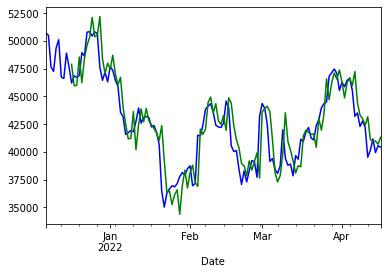

In [ ]:
compare_pred(predictions)

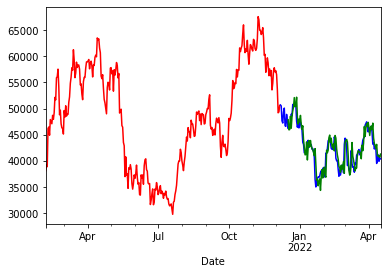

In [ ]:
plot_predictions(predictions)

In [ ]:
X_train.shape, Y_train.shape

((295, 10, 6), (295, 1))

In [ ]:
X_test.shape, Y_test.shape

((121, 10, 6), (121, 1))

In [ ]:
# recurrent model

recurrent = Sequential()
recurrent.add(InputLayer((10, 6)))
recurrent.add(GRU(64))
recurrent.add(Dense(32, 'relu'))
recurrent.add(Dense(1, 'linear'))
recurrent.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 64)                13824     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 15,937
Trainable params: 15,937
Non-trainable params: 0
_________________________________________________________________


In [ ]:
recurrent_c= ModelCheckpoint('recurrent/', save_best_only=True)
recurrent.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [ ]:
recurrent.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=40, callbacks=[recurrent_c])

Epoch 1/40
 8/10 [=======================>......] - ETA: 0s - loss: 0.3253 - root_mean_squared_error: 0.5703 

10/10 [==============================] - 8s 618ms/step - loss: 0.2933 - root_mean_squared_error: 0.5416 - val_loss: 0.0731 - val_root_mean_squared_error: 0.2704
Epoch 2/40
 9/10 [==========================>...] - ETA: 0s - loss: 0.1024 - root_mean_squared_error: 0.3200

10/10 [==============================] - 5s 500ms/step - loss: 0.1010 - root_mean_squared_error: 0.3177 - val_loss: 0.0598 - val_root_mean_squared_error: 0.2445
Epoch 3/40
 6/10 [=================>............] - ETA: 0s - loss: 0.0862 - root_mean_squared_error: 0.2936

10/10 [==============================] - 5s 572ms/step - loss: 0.0808 - root_mean_squared_error: 0.2843 - val_loss: 0.0594 - val_root_mean_squared_error: 0.2436
Epoch 4/40
 8/10 [=======================>......] - ETA: 0s - loss: 0.0673 - root_mean_squared_error: 0.2593

10/10 [==============================] - 5s 499ms/step - loss: 0.0681 - root_mean_squared_error: 0.2609 - val_loss: 0.0527 - val_root_mean_squared_error: 0.2296
Epoch 5/40
10/10 [==============================] - 0s 13ms/step - loss: 0.0637 - root_mean_squared_error: 0.2524 - val_loss: 0.0661 - val_root_mean_squared_error: 0.2571
Epoch 6/40
10/10 [==============================] - 0s 11ms/step - loss: 0.0608 - root_mean_squared_error: 0.2465 - val_loss: 0.0563 - val_root_mean_squared_error: 0.2373
Epoch 7/40
10/10 [==============================] - 0s 12ms/step - loss: 0.0579 - root_mean_squared_error: 0.2405 - val_loss: 0.0539 - val_root_mean_squared_error: 0.2321
Epoch 8/40
10/10 [==============================] - 0s 12ms/step - loss: 0.0548 - root_mean_squared_error: 0.2340 - val_loss: 0.0563 - val_root_mean_squared_error: 0.2372
Epoch 9/40
10/10 [==============================] - 0s 13ms/step - loss: 0.0528 - root_mean_squared_error: 0.2299 - val_loss: 0.0550 - val_root_mean_square

10/10 [==============================] - 5s 504ms/step - loss: 0.0513 - root_mean_squared_error: 0.2266 - val_loss: 0.0527 - val_root_mean_squared_error: 0.2295
Epoch 11/40
10/10 [==============================] - 0s 13ms/step - loss: 0.0523 - root_mean_squared_error: 0.2287 - val_loss: 0.0535 - val_root_mean_squared_error: 0.2313
Epoch 12/40
10/10 [==============================] - 0s 12ms/step - loss: 0.0495 - root_mean_squared_error: 0.2224 - val_loss: 0.0543 - val_root_mean_squared_error: 0.2329
Epoch 13/40
 8/10 [=======================>......] - ETA: 0s - loss: 0.0467 - root_mean_squared_error: 0.2160

10/10 [==============================] - 5s 556ms/step - loss: 0.0477 - root_mean_squared_error: 0.2184 - val_loss: 0.0522 - val_root_mean_squared_error: 0.2285
Epoch 14/40
 8/10 [=======================>......] - ETA: 0s - loss: 0.0462 - root_mean_squared_error: 0.2149

10/10 [==============================] - 4s 492ms/step - loss: 0.0489 - root_mean_squared_error: 0.2211 - val_loss: 0.0506 - val_root_mean_squared_error: 0.2249
Epoch 15/40
 7/10 [====================>.........] - ETA: 0s - loss: 0.0480 - root_mean_squared_error: 0.2191

10/10 [==============================] - 5s 558ms/step - loss: 0.0472 - root_mean_squared_error: 0.2172 - val_loss: 0.0489 - val_root_mean_squared_error: 0.2211
Epoch 16/40
10/10 [==============================] - 0s 13ms/step - loss: 0.0500 - root_mean_squared_error: 0.2237 - val_loss: 0.0511 - val_root_mean_squared_error: 0.2260
Epoch 17/40
10/10 [==============================] - 0s 11ms/step - loss: 0.0486 - root_mean_squared_error: 0.2206 - val_loss: 0.0509 - val_root_mean_squared_error: 0.2256
Epoch 18/40
 9/10 [==========================>...] - ETA: 0s - loss: 0.0454 - root_mean_squared_error: 0.2131

10/10 [==============================] - 6s 633ms/step - loss: 0.0449 - root_mean_squared_error: 0.2120 - val_loss: 0.0470 - val_root_mean_squared_error: 0.2168
Epoch 19/40
10/10 [==============================] - 0s 10ms/step - loss: 0.0460 - root_mean_squared_error: 0.2144 - val_loss: 0.0526 - val_root_mean_squared_error: 0.2294
Epoch 20/40
 9/10 [==========================>...] - ETA: 0s - loss: 0.0441 - root_mean_squared_error: 0.2099

10/10 [==============================] - 5s 549ms/step - loss: 0.0442 - root_mean_squared_error: 0.2103 - val_loss: 0.0458 - val_root_mean_squared_error: 0.2141
Epoch 21/40
10/10 [==============================] - 0s 13ms/step - loss: 0.0439 - root_mean_squared_error: 0.2094 - val_loss: 0.0465 - val_root_mean_squared_error: 0.2157
Epoch 22/40
10/10 [==============================] - 0s 11ms/step - loss: 0.0446 - root_mean_squared_error: 0.2113 - val_loss: 0.0471 - val_root_mean_squared_error: 0.2169
Epoch 23/40
10/10 [==============================] - 0s 11ms/step - loss: 0.0427 - root_mean_squared_error: 0.2067 - val_loss: 0.0462 - val_root_mean_squared_error: 0.2150
Epoch 24/40
 7/10 [====================>.........] - ETA: 0s - loss: 0.0444 - root_mean_squared_error: 0.2106

10/10 [==============================] - 5s 502ms/step - loss: 0.0432 - root_mean_squared_error: 0.2079 - val_loss: 0.0422 - val_root_mean_squared_error: 0.2053
Epoch 25/40
10/10 [==============================] - 0s 12ms/step - loss: 0.0418 - root_mean_squared_error: 0.2045 - val_loss: 0.0438 - val_root_mean_squared_error: 0.2094
Epoch 26/40
 7/10 [====================>.........] - ETA: 0s - loss: 0.0432 - root_mean_squared_error: 0.2079

10/10 [==============================] - 5s 562ms/step - loss: 0.0420 - root_mean_squared_error: 0.2050 - val_loss: 0.0412 - val_root_mean_squared_error: 0.2030
Epoch 27/40
10/10 [==============================] - 0s 12ms/step - loss: 0.0410 - root_mean_squared_error: 0.2025 - val_loss: 0.0465 - val_root_mean_squared_error: 0.2156
Epoch 28/40
 9/10 [==========================>...] - ETA: 0s - loss: 0.0418 - root_mean_squared_error: 0.2043

10/10 [==============================] - 4s 473ms/step - loss: 0.0420 - root_mean_squared_error: 0.2048 - val_loss: 0.0398 - val_root_mean_squared_error: 0.1995
Epoch 29/40
10/10 [==============================] - 0s 11ms/step - loss: 0.0408 - root_mean_squared_error: 0.2020 - val_loss: 0.0432 - val_root_mean_squared_error: 0.2079
Epoch 30/40
10/10 [==============================] - 0s 11ms/step - loss: 0.0423 - root_mean_squared_error: 0.2057 - val_loss: 0.0466 - val_root_mean_squared_error: 0.2159
Epoch 31/40
10/10 [==============================] - 0s 12ms/step - loss: 0.0402 - root_mean_squared_error: 0.2005 - val_loss: 0.0406 - val_root_mean_squared_error: 0.2016
Epoch 32/40
10/10 [==============================] - 0s 11ms/step - loss: 0.0400 - root_mean_squared_error: 0.2001 - val_loss: 0.0447 - val_root_mean_squared_error: 0.2113
Epoch 33/40
10/10 [==============================] - 0s 10ms/step - loss: 0.0388 - root_mean_squared_error: 0.1969 - val_loss: 0.0419 - val_root_mean_s

10/10 [==============================] - 5s 548ms/step - loss: 0.0396 - root_mean_squared_error: 0.1991 - val_loss: 0.0395 - val_root_mean_squared_error: 0.1989
Epoch 36/40
10/10 [==============================] - 0s 12ms/step - loss: 0.0383 - root_mean_squared_error: 0.1956 - val_loss: 0.0413 - val_root_mean_squared_error: 0.2032
Epoch 37/40
 8/10 [=======================>......] - ETA: 0s - loss: 0.0407 - root_mean_squared_error: 0.2018

10/10 [==============================] - 5s 501ms/step - loss: 0.0387 - root_mean_squared_error: 0.1967 - val_loss: 0.0388 - val_root_mean_squared_error: 0.1971
Epoch 38/40
10/10 [==============================] - 0s 12ms/step - loss: 0.0391 - root_mean_squared_error: 0.1978 - val_loss: 0.0479 - val_root_mean_squared_error: 0.2188
Epoch 39/40
10/10 [==============================] - 0s 12ms/step - loss: 0.0385 - root_mean_squared_error: 0.1962 - val_loss: 0.0398 - val_root_mean_squared_error: 0.1994
Epoch 40/40
10/10 [==============================] - 0s 11ms/step - loss: 0.0388 - root_mean_squared_error: 0.1969 - val_loss: 0.0483 - val_root_mean_squared_error: 0.2197


In [ ]:
predictions = recurrent.predict(X_test)

4/4 [==============================] - 0s 4ms/step


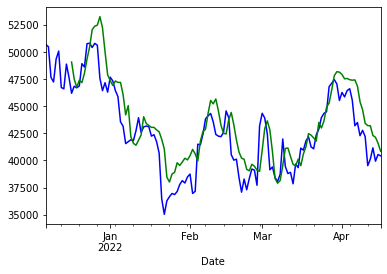

In [ ]:
compare_pred(predictions)

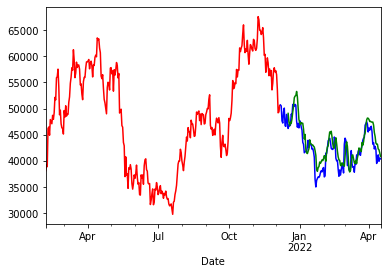

In [ ]:
plot_predictions(predictions)

In [ ]:
def calculate_r2(predictions, ground_truth):
    predictions = targetScaler.inverse_transform(predictions)
    score = r2_score(predictions, ground_truth)*100
    return score

In [ ]:
# calculate R2 metrics

regressor_predictions = regressor.predict(X_test.reshape(-1, 10*6))
recurrent_predictions = recurrent.predict(X_test)

regressor_r2 = calculate_r2(regressor_predictions, test_df['Close'][WINDOW_SIZE:])
recurrent_r2 = calculate_r2(recurrent_predictions, test_df['Close'][WINDOW_SIZE:])


print(f'R2 for Linear Regression model -> {regressor_r2:.2f}%')
print(f'R2 for GRU model -> {recurrent_r2:.2f}%')



4/4 [==============================] - 0s 7ms/step
R2 for Linear Regression model -> 78.11%
R2 for GRU model -> 64.81%
